In [298]:
"""
This notebook contains some analytics for the azimuthal scans run in the soliton
beamtime.
""";


In [299]:
"""
Firstly, do some housekeeping; store paths.
"""

from typing import List
import os
import re

# First construct a path to where the data is stored on my machine.
local_data_dir = "/Users/richard/Data/i10/CSL_Feb_2022/azimuthal_scans/"

# Get all the nexus files and scan directories in the data directory.
nexus_files = sorted(
    [f for f in os.listdir(local_data_dir) if f.endswith('.nxs')]
)
scan_dirs = sorted(
    [d for d in os.listdir(local_data_dir) if d.endswith('files')]
)

# The first scan number in the script.
first_scan = 687537

# The field values in the field sweeps.
field_values = list(range(31))


In [300]:
"""
Now make some convenience functions for working with scan numbers and file
names.
"""

def name_to_scan_number(dir_or_file_name: str) -> int:
    """
    Takes the name of a scan directory or nexus file. Outputs the scan number.

    Args:
        dir_or_file_name:
            The name of the directory or file.
    
    Returns:
        The scan number.
    """
    split_name = re.split('\W', dir_or_file_name)
    for maybe_scan_number in split_name:
        try:
            return int(maybe_scan_number)
        except ValueError:
            continue

def scan_to_angle(dir_or_file_name: str) -> float:
    """
    Takes the name of a scan directory or nexus file name. Outputs the azimuthal
    angle at which the field was applied in the scan.

    Args:
        dir_or_file_name:
            The name of the directory or file.

    Returns:
        The scan's corresponding azimuthal angle.
    """
    scan_number = name_to_scan_number(dir_or_file_name)
    return (scan_number - first_scan)*1.5

def _angle_to_scan_no(angle: float) -> int:
    """
    Converts input angle to integer nth scan number.
    """
    if float(angle) not in np.arange(0, 180, 1.5):
        raise ValueError("Angle was not scanned.")
    return int(angle/1.5)

In [301]:
"""
Some convenience functions for working with images.
"""

import numpy as np
from PIL import Image

def get_path(scan_dir: str, field_magnitude: int):
    """
    Each scan has several .tiff files, one for each field magnitude in
    range(31).
    
    Args:
        scan_dir:
            The name of a scan directory or file.
        field_magnitude:
            The magnitude of the field of interest
    
    Returns:
        The path to the corresponding .tiff file.
    """
    local_tiff_name = f"pixis-{field_magnitude}.tiff"
    return os.path.join(local_data_dir, scan_dir, local_tiff_name)


def get_tiff(scan_dir: str, field_magnitude: int) -> np.ndarray:
    """
    Each scan has several .tiff files, one for each field magnitude in
    range(31).
    
    Args:
        scan_dir:
            The name of a scan directory or file.
        field_magnitude:
            The magnitude of the field of interest

    Returns:
        A numpy array representing the .tiff file.
    """
    full_tiff_path = get_path(scan_dir, field_magnitude)
    return np.array(Image.open(full_tiff_path)).astype(np.float64)


In [302]:
"""
Prepare functions for dealing with the image background.
"""

def get_rough_background(scan_dir: str) -> np.ndarray:
    """
    Assume that we can model the background as an image taken in the field
    polarized state. Assume that we field polarize at the maximum field value
    of 30 mT. In this case, the background is just the 30 mT image; return it.

    Args:
        scan_dir:
            The scan directory of interest.
    
    Returns:
        A simple estimate of the background for the images in that scan
        directory.
    """
    return get_tiff(scan_dir, 30)


In [303]:
"""
A simple imshow to make life a bit easier.
"""

import matplotlib.pyplot as plt
from typing import Tuple

def imshow(img: np.ndarray, figsize: Tuple[int]=(20, 20),
           cmap: str='jet') -> None:
    """
    Imshow, but with pretty colours and a big size.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    picture = ax.imshow(img, cmap=cmap)
    fig.colorbar(picture, ax=ax)
    fig.show()


In [304]:
"""
A plotly imshow. Very laggy, but nice for manual data inspection.
"""
import plotly.express as px

def plotly_imshow(img: np.ndarray):
    """
    Imshow, plotly version.
    """
    px.imshow(img, color_continuous_scale="jet").show()



In [305]:
"""
The following cells are demonstration of the analysis routine, but used only on
one image.
""";


In [306]:
"""
Keep track of positions for masking/tracking purposes!
"""
# Calculated manually
beamstop_top = 1082
beamstop_bottom = 1284
beamstop_left = 948
beamstop_right = 1145

beam_centre_x = 1045
beam_centre_y = 1175

/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_43107/3558669480.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


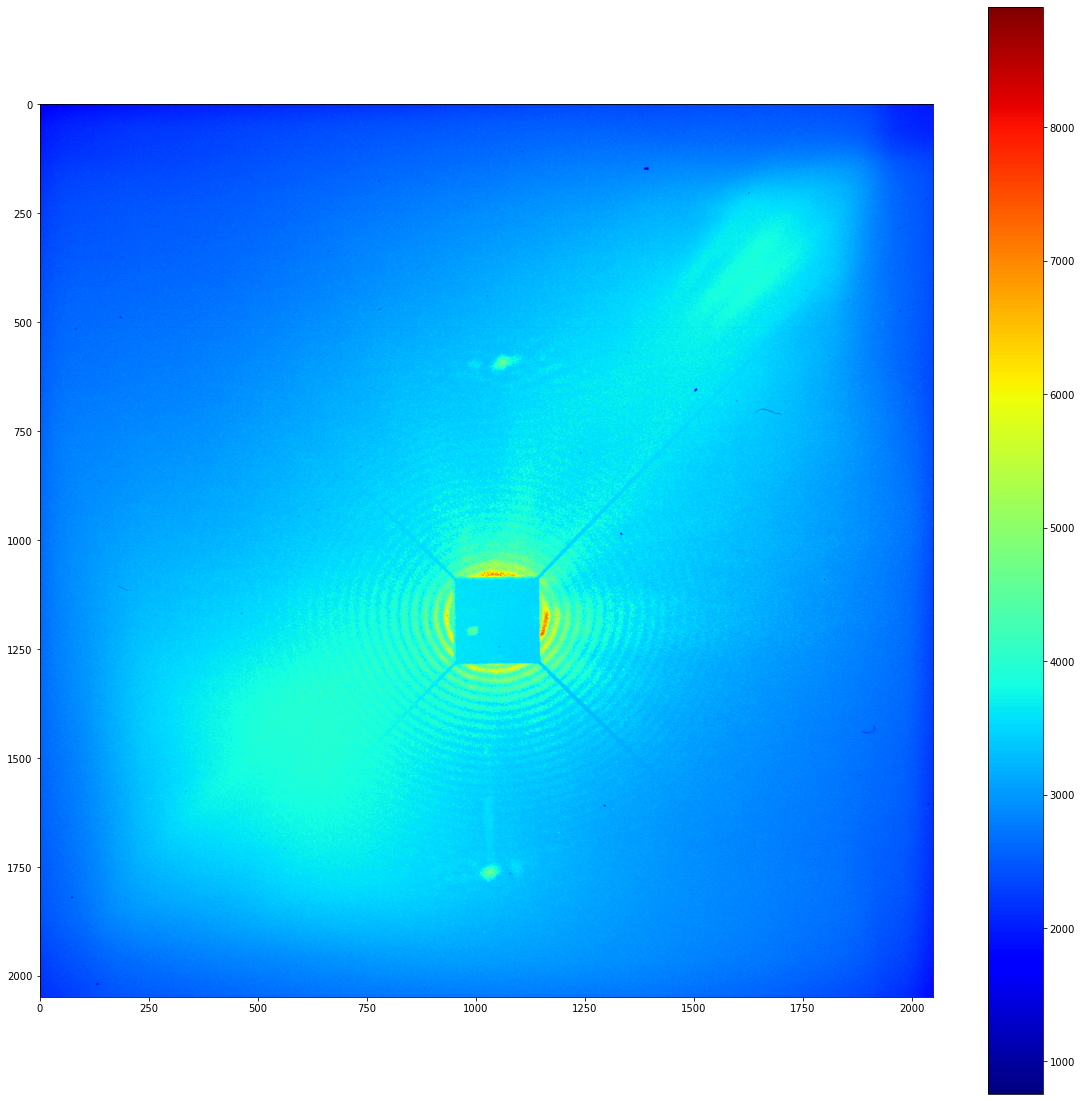

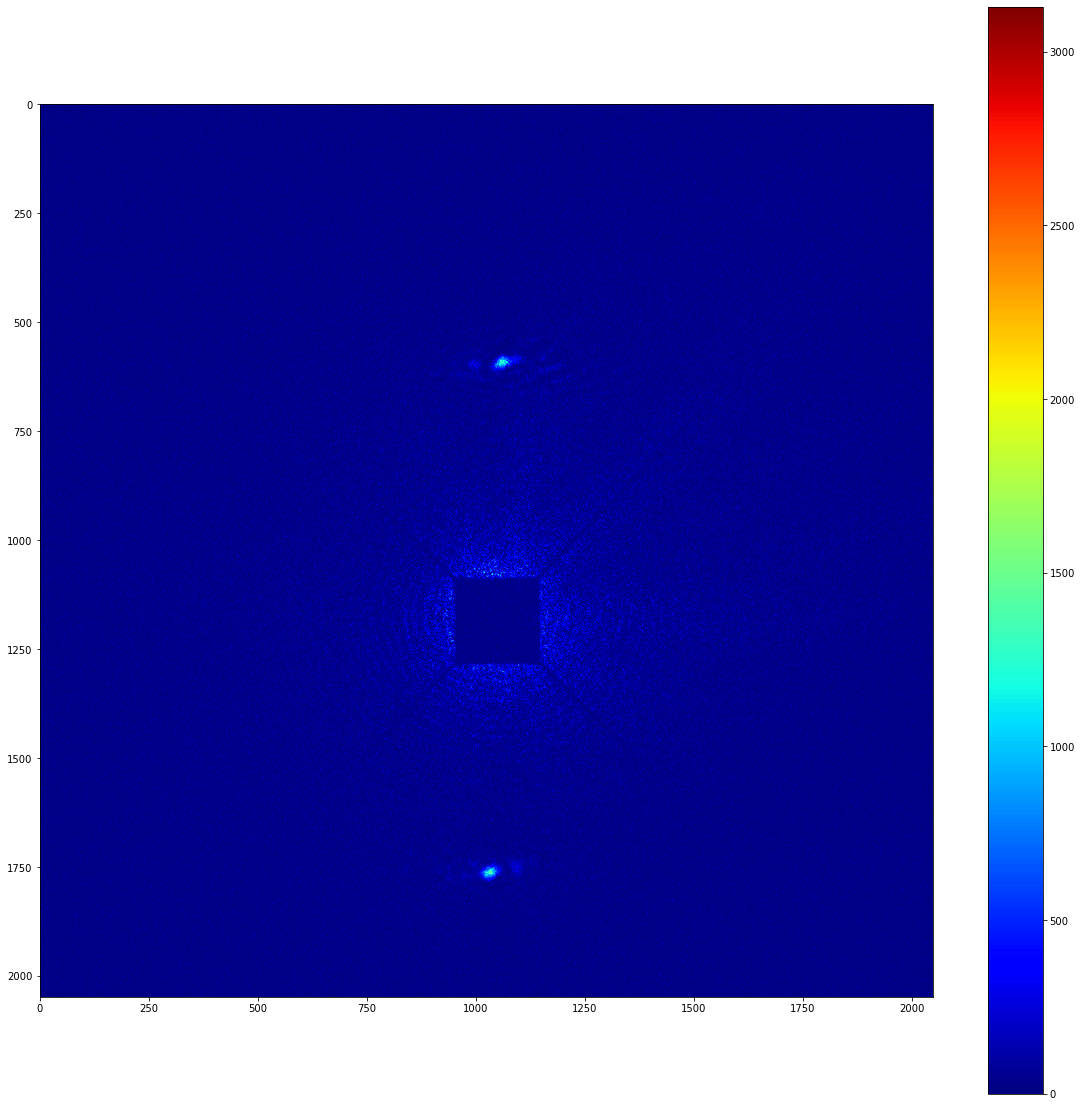

In [307]:
"""
Subtract the background.
"""

import plotly.express as px

# Pick a scan directory.
scan_angle = 0
scan_dir = scan_dirs[_angle_to_scan_no(scan_angle)]

# Get the first image; background subtract it.
scan_field = 0 # units of mT
img = get_tiff(scan_dir, scan_field)
imshow(img)
# plotly_imshow(img)

# Now plot the background subtracted image.
img -= get_rough_background(scan_dir)

# Kill any pixels that were below the background.
img = np.clip(img, 0, np.max(img))
imshow(img)


In [308]:
"""
This made a big improvement, but we've still got obvious noise, particularly
near the centre. We don't want to mask this, since we might end up masking
soliton peaks later. 

Using a wavelet representation of the above image, this is quite simple; we can
just rotate the image in wavelet space out of the high frequency wavelet domain.
"""

import pywt
import matplotlib.pyplot as plt

# Fairly arbitrary choice of a wavelet.
wavelet_choice = "sym4"

coeffs = pywt.wavedec(img, wavelet_choice)

# Plot the wavelet coefficient arrays.
for arr in coeffs:
    # imshow(arr, figsize=(10, 10))
    pass


/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_43107/3558669480.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


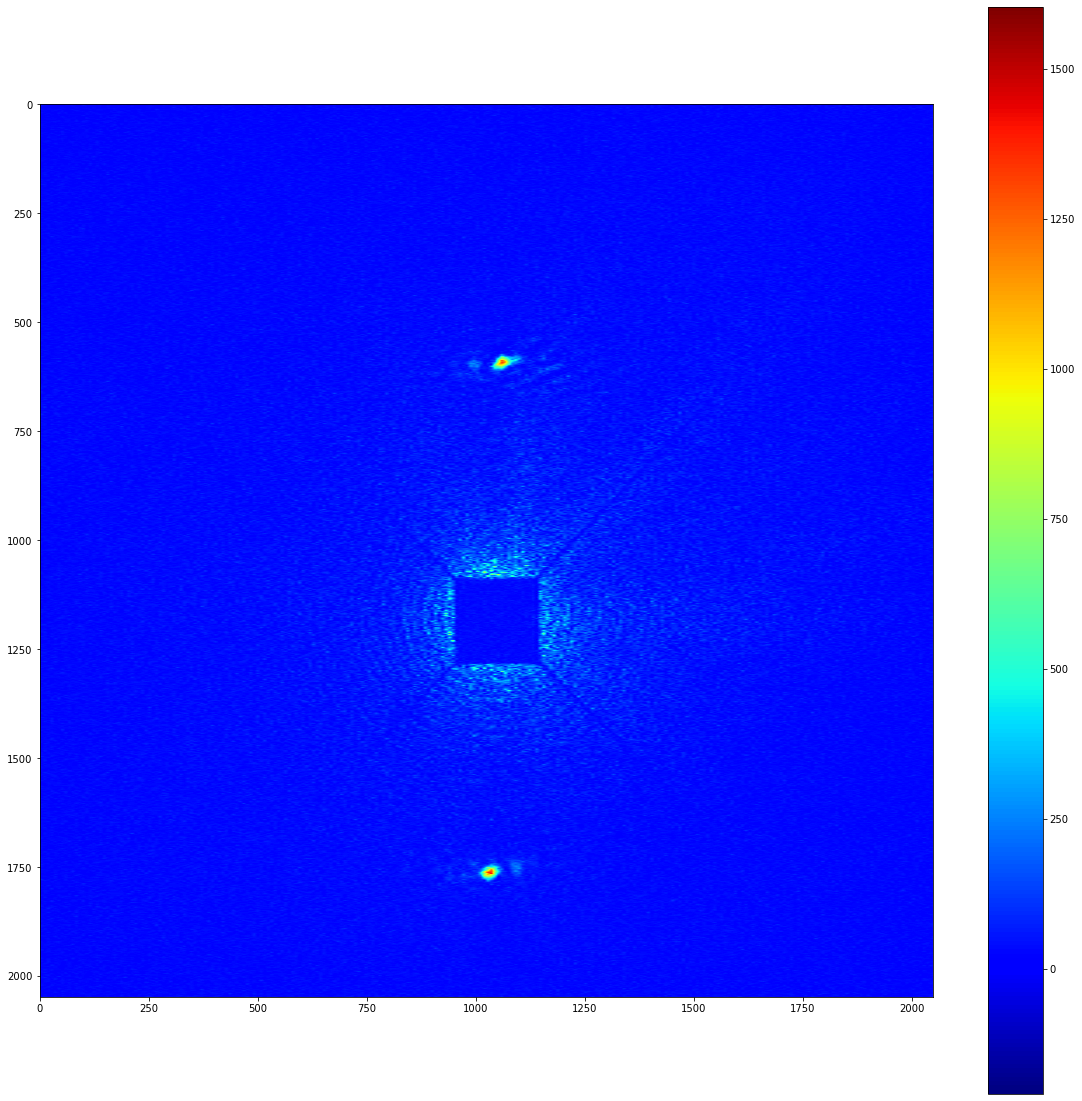

In [309]:
"""
Now we want to try to manipulate the wavelet coefficients and inverse transform.
"""

new_coeffs = [np.copy(arr) for arr in coeffs]

new_coeffs[-1] = np.zeros_like(new_coeffs[-1])

img_rec = pywt.waverec(new_coeffs, wavelet_choice)
# imshow(img_rec)

"""
Okay, that was a bit crude. As well as removing the ultra-high frequncy
components, lets also remove all low amplitude wavelet coefficients. The idea
here is that the amplitude of wavelets representing noise should be much smaller
than the amplitude of wavelets used to reconstruct the signal (so this is
equivalent to assuming signal >> noise).
"""
max_coeff = 0
for arr in new_coeffs:
    max_coeff = np.max(arr) if np.max(arr) > max_coeff else max_coeff

new_coeffs[-2] = np.zeros_like(new_coeffs[-2])
new_coeffs[-3] = np.zeros_like(new_coeffs[-3])


# An arbitrary choice.
wavelet_cutoff = 0.2
min_coeff = max_coeff * wavelet_cutoff

new_coeffs = [np.where(
    ((arr > min_coeff).any() or (arr < -min_coeff).any()).any(), arr, 0
) for arr in new_coeffs]


denoised_img = pywt.waverec(new_coeffs, wavelet_choice)
imshow(denoised_img)


/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_43107/3558669480.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


The standard deviation of pixels in the image is: 25.32248886684521.


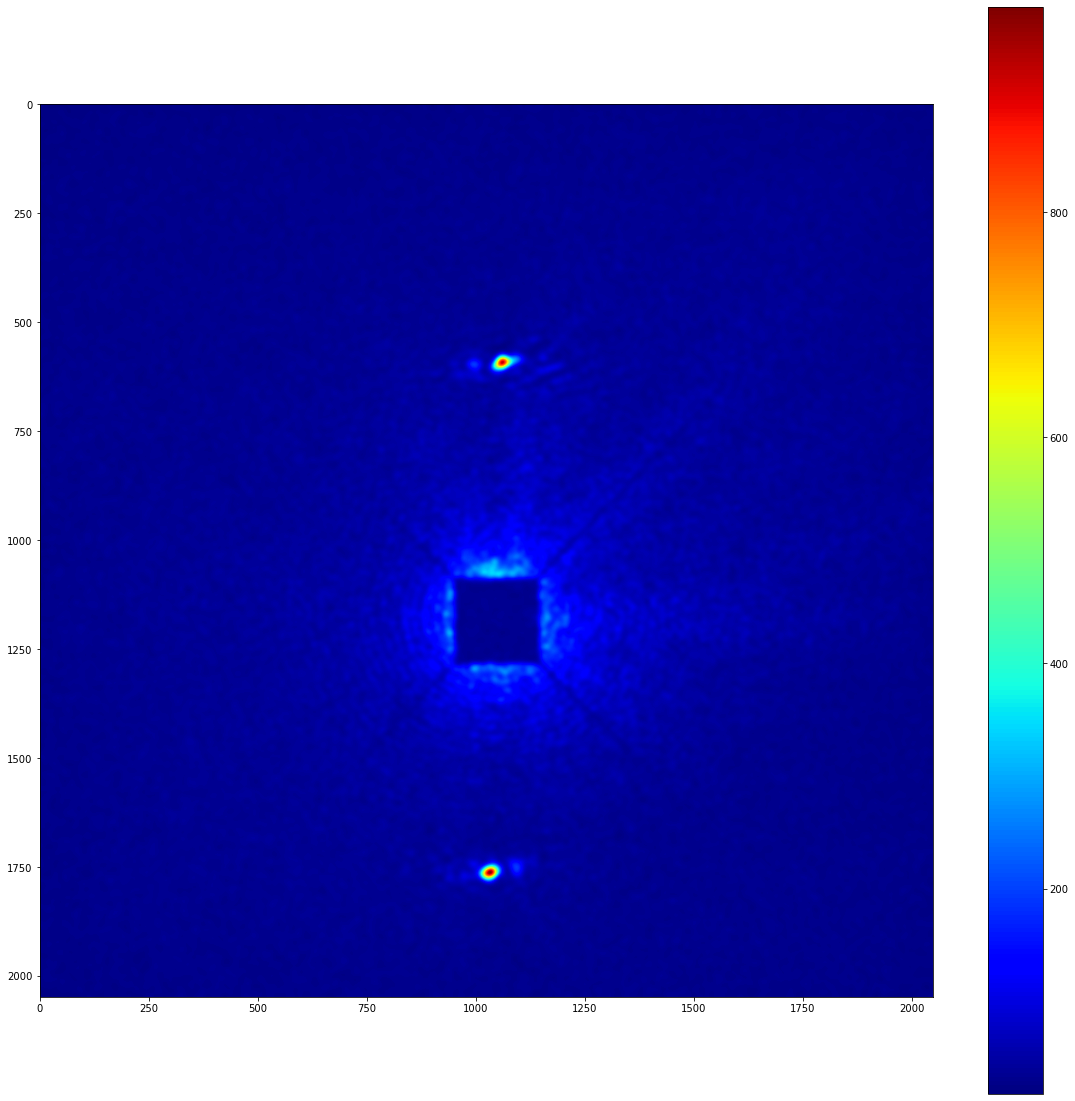

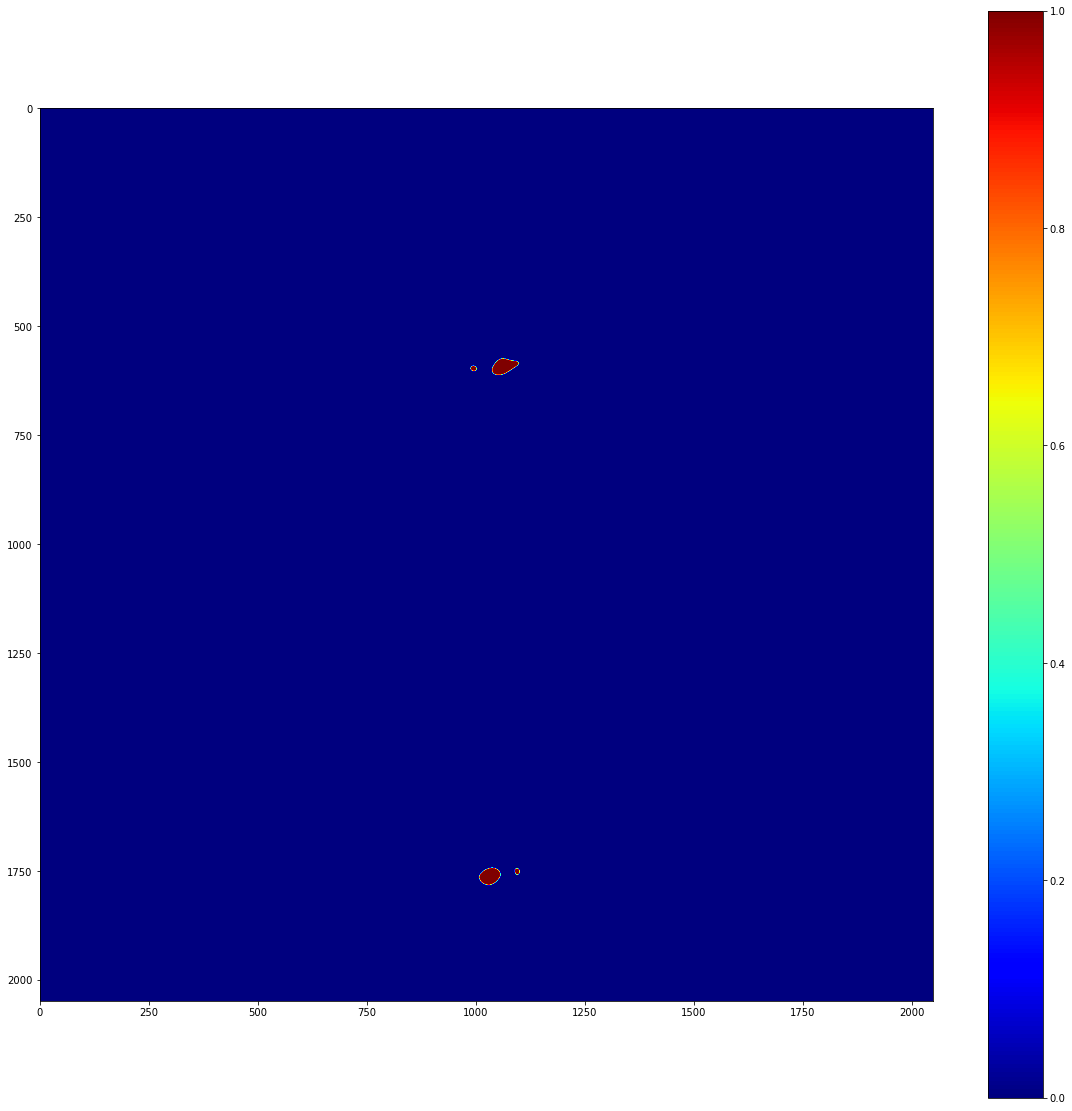

In [310]:
"""
Now we want to do some clustering. First, calculate local means.
"""
from scipy.ndimage import uniform_filter, gaussian_filter, generic_filter

# First do a bit of local averaging. This will hugely decrease the number of
# tiny clusters that show up.
signal_length_scale = 20
local_signal = gaussian_filter(denoised_img, int(signal_length_scale/3))
imshow(local_signal)

# Arbitrary choice; units of pixels.
bkg_length_scale = 100

# Calculate the local mean at every point in the image.
local_bkg_levels = uniform_filter(local_signal, bkg_length_scale)

# Calculate the local standard deviation at every point in the image.
total_deviation = np.std(local_signal)

pixels_to_cluster = np.where(
    local_signal > local_bkg_levels + 4*total_deviation, 1, 0)
# imshow(pixels_to_cluster, cmap='gray')

print(f"The standard deviation of pixels in the image is: {total_deviation}.")

"""
Make a mask that will kill clusters whose statistics were fudged by the presence
of the beamstop.
"""

mask = np.ones_like(pixels_to_cluster)
mask[(beamstop_top-bkg_length_scale):(beamstop_bottom+bkg_length_scale),
     (beamstop_left-bkg_length_scale):(beamstop_right+bkg_length_scale)] = 0

pixels_to_cluster *= mask
imshow(pixels_to_cluster, cmap='jet')


Detected 2 clusters.


/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_43107/3558669480.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


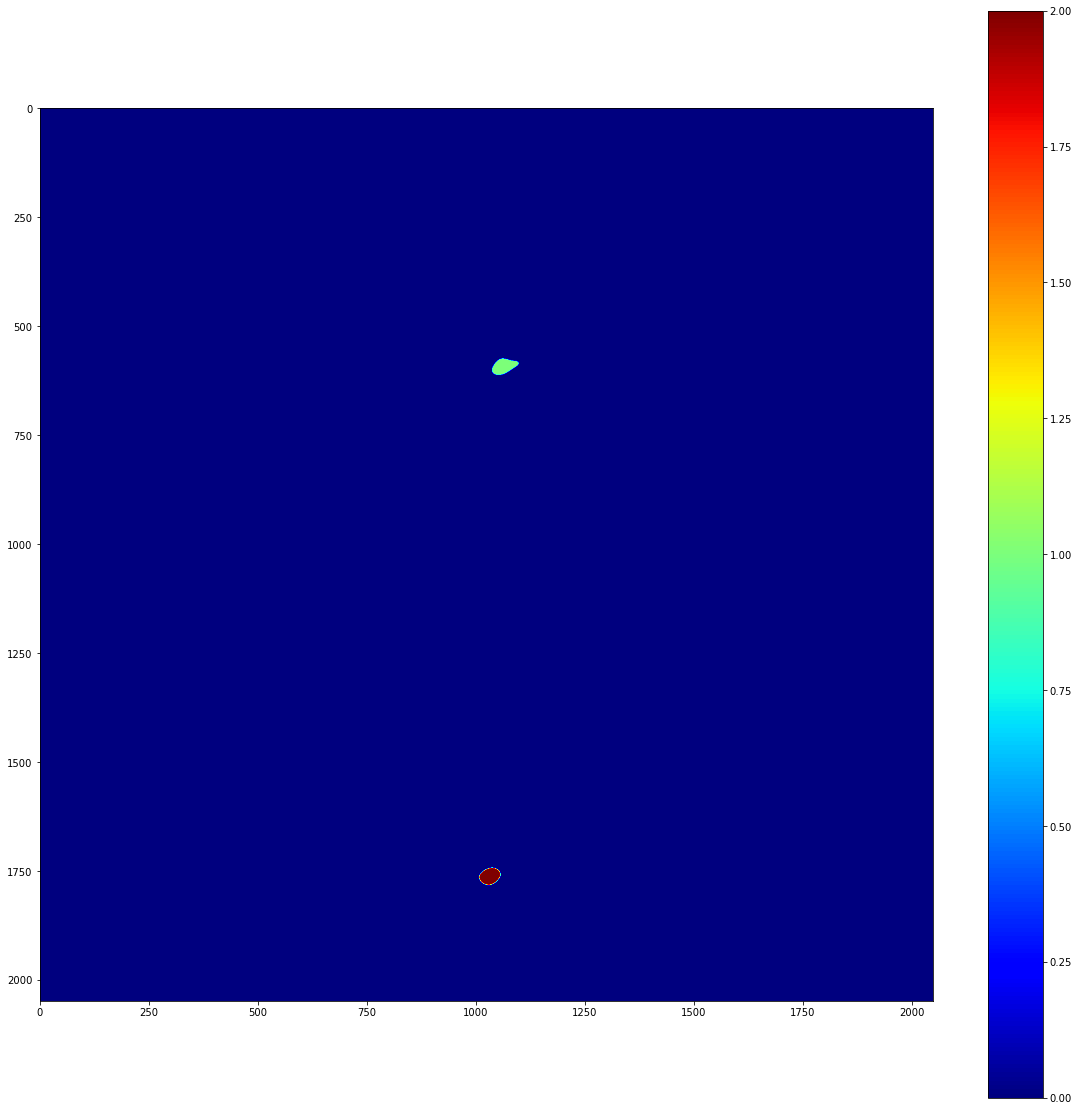

In [311]:
"""
Okay. We have some significance clusters. Now what we *really* want to do is
actually cluster those! I could write this in pure python, but instead I'll hack
scikit learn's DBSCAN implementation to work with our data.
"""
import cluster
import importlib
from sklearn.cluster import DBSCAN

# Get all of the coordinates of the significant pixels.
pixels_y, pixels_x = np.where(pixels_to_cluster == 1)

# Massage these pixels into the form that sklearn wants to see.
pixel_coords = np.zeros((len(pixels_x), 2))
pixel_coords[:, 0] = pixels_x
pixel_coords[:, 1] = pixels_y

# Run the DBSCAN algorithm. Set min_samples to one; in theory we've already done
# all the selection, so we just want to run trivial clustering.
dbscan = DBSCAN(eps=20, min_samples=400).fit(pixel_coords)

num_clusters = np.max(dbscan.labels_) + 1  # clusters use zero counting
print(f"Detected {num_clusters} clusters.")

"""
We know how many clusters to expect. Lets separate everything out into distinct
clusters. We'll do this using the cluster module I wrote.
"""
importlib.reload(cluster)


# Required because I've been developing the module while testing it. Unless
# you're actively developing the cluster module, you can comment out the
# following two lines.
importlib.reload(cluster)

clusters = cluster.Cluster.from_DBSCAN(pixel_coords, dbscan.labels_)

# Lets check that it worked.
clustered_img = np.zeros_like(img)
for i, cluster in enumerate(clusters):
    pixels_x, pixels_y = cluster.pixel_indices
    clustered_img[pixels_y, pixels_x] = i+1

imshow(clustered_img)


In [312]:
"""
Now we can do things like classify peaks into the soliton/cone phases.
"""

for i, cluster in enumerate(clusters):
    cluster_x = cluster.mean[0]
    cluster_y = cluster.mean[1]

    dx = beam_centre_x - cluster_x
    dy = cluster_y - beam_centre_y

    cluster_angle = np.arctan2(dx, dy)*180/np.pi

    print(f"Cluster {i} is at position {cluster_x}, {cluster_y}; its azimuthal "
          f"angle is {cluster_angle}.")

    soliton_angle_1 = scan_angle
    soliton_angle_2 = scan_angle - 180
    cone_angle_1 = scan_angle + 90
    cone_angle_2 = scan_angle - 90

    if np.isclose(soliton_angle_1, cluster_angle, atol=15) or \
       np.isclose(soliton_angle_2, cluster_angle, atol=15):
        print(f"Cluster {i} is a soliton.")
    elif np.isclose(cone_angle_1, cluster_angle, atol=15) or \
         np.isclose(cone_angle_2, cluster_angle, atol=15):
       print(f"Cluster {i} is a cone.")
    else:
        print(f"Cluster {i} is unknown. Check manually.")
    

Cluster 0 is at position 1063.4561403508771, 592.1156595191683; its azimuthal angle is -178.18642277180157.
Cluster 0 is a soliton.
Cluster 1 is at position 1031.3061224489795, 1761.3736805066853; its azimuthal angle is 1.3378137947198205.
Cluster 1 is a soliton.


In [313]:
"""
Write some code to extract the intensity from a cluster. Use this to work out
whether or not a cluster is noise.
"""
assert 1 == 2
import cluster

def intensity_from_cluster(cluster: cluster.Cluster, field: int, 
                           angle: float) -> float:
    """
    Returns the background subtracted intensity contained within a cluster.
    """
    # Initialize the CCDImage object.
    scan_dir_idx = int(angle/1.5)
    scan_dir = scan_dirs[scan_dir_idx]
    tiff = get_tiff(scan_dir, field)
    ccdImage = CCDImage(tiff, get_rough_background(scan_dir), mask,
            metadata)
    
    # Subtract the background.
    ccdImage.subtract_bkg()

    # Integrate under the cluster.
    x, y = cluster.pixel_indices
    return np.sum(ccdImage.data[y, x])

def remove_noise_clusters(clusters: List[cluster.Cluster], field: int, 
                          angle: float, n_sigma: float) -> None:
    """
    Removes noise clusters from the list of clusters passed as an argument.

    Args:
        clusters:
            The list of clusters to process.
        field:
            The field at which this cluster was taken.
        angle:
            The azimuthal angle at which this field was applied.
        n_sigma:
            The number of standard deviations below the mean that a cluster has
            to be to be classified as noise.
    """
    # Do the stats.
    sums = [intensity_from_cluster(x, field, angle) for x in clusters]
    avg = np.mean(sums)
    devs = [
        np.abs(intensity_from_cluster(x, field, angle) - avg) for x in clusters]
    stddev = np.mean(devs)

    # Delete insignificant clusters.
    for i, _ in enumerate(sums):
        if sums[-i] < stddev * n_sigma:
            del clusters[-i]

remove_noise_clusters(clusters, scan_field, scan_angle, n_sigma=2)

# Show what it looks like with insignificant clusters removed.
clustered_img = np.zeros_like(img)
for i, cluster in enumerate(clusters):
    pixels_x, pixels_y = cluster.pixel_indices
    clustered_img[pixels_y, pixels_x] = i+1

imshow(clustered_img)


AssertionError: 

In [ ]:
"""
And there we have it! From there, calculating scattering vectors etc. is
trivial. To simplify running this code on lots of data, lets use the convenience
class I've written called CCDImage.
""";
assert 1 == 2

AssertionError: 

In [ ]:

from ccd_image import Metadata, CCDImage


# We can use this metadata for all the scans.
metadata = Metadata(beam_centre_x, beam_centre_y)

# Iterate over all of the scans.
mean_radii = []
ccd_images = []

for scan_dir in scan_dirs:
    print(f"Processing scan {scan_dir}.")

    zero_field_tiff = get_tiff(scan_dir, 0)

    ccdImage = CCDImage(zero_field_tiff, get_rough_background(scan_dir),
                        mask, metadata)
    
    ccdImage.subtract_bkg()
    ccdImage.wavelet_denoise()
    ccdImage.init_significant_pixels(6, 100)
    mean_radii.append(ccdImage.mean_signal_radius)
    ccd_images.append(ccdImage)

print(mean_radii)


Processing scan 687537-pixis-files.
Processing scan 687538-pixis-files.
Processing scan 687539-pixis-files.
Processing scan 687540-pixis-files.
Processing scan 687541-pixis-files.
Processing scan 687542-pixis-files.
Processing scan 687543-pixis-files.
Processing scan 687544-pixis-files.
Processing scan 687545-pixis-files.
Processing scan 687546-pixis-files.
Processing scan 687547-pixis-files.
Processing scan 687548-pixis-files.
Processing scan 687549-pixis-files.
Processing scan 687550-pixis-files.
Processing scan 687551-pixis-files.
Processing scan 687552-pixis-files.
Processing scan 687553-pixis-files.
Processing scan 687554-pixis-files.
Processing scan 687555-pixis-files.
Processing scan 687556-pixis-files.
Processing scan 687557-pixis-files.
Processing scan 687558-pixis-files.
Processing scan 687559-pixis-files.
Processing scan 687560-pixis-files.
Processing scan 687561-pixis-files.
Processing scan 687562-pixis-files.
Processing scan 687563-pixis-files.
Processing scan 687564-pixis

/opt/homebrew/Caskroom/miniforge/base/envs/science_general/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/science_general/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing scan 687591-pixis-files.
Processing scan 687592-pixis-files.
Processing scan 687593-pixis-files.
Processing scan 687594-pixis-files.
Processing scan 687595-pixis-files.
Processing scan 687596-pixis-files.
Processing scan 687597-pixis-files.
Processing scan 687598-pixis-files.
Processing scan 687599-pixis-files.
Processing scan 687600-pixis-files.
Processing scan 687601-pixis-files.
Processing scan 687602-pixis-files.
Processing scan 687603-pixis-files.
Processing scan 687604-pixis-files.
Processing scan 687605-pixis-files.
Processing scan 687606-pixis-files.
Processing scan 687607-pixis-files.
Processing scan 687608-pixis-files.
Processing scan 687609-pixis-files.
Processing scan 687610-pixis-files.
Processing scan 687611-pixis-files.
Processing scan 687612-pixis-files.
Processing scan 687613-pixis-files.
Processing scan 687614-pixis-files.
Processing scan 687615-pixis-files.
Processing scan 687616-pixis-files.
Processing scan 687617-pixis-files.
Processing scan 687618-pixis

KeyboardInterrupt: 

In [ ]:
"""
I don't know the detector distance right now. Instead, I'll just fix the 0mT
data point. We're basically fitting a function that looks like
$\lambda = k/pixels$; k is "fit_constant".
"""

pixel_radii = np.ma.array(mean_radii, mask=np.isnan(mean_radii))
avg_radius_over_every_angle = np.mean(radii)
fit_constant = avg_radius_over_every_angle * 120 # To give units of nm
radii_in_nm = fit_constant/radii
stddev_radii_in_nm = np.sqrt(np.var(radii_in_nm))

print(f"The fitting constant was found to be: {fit_constant}")
print(f"The mean of all 0 mT radii has been set to 120 nm.")
print(f"Standard deviation of 0 mT radii over runs {stddev_radii_in_nm} nm")


The fitting constant was found to be: 45567.40770127343
The mean of all 0 mT radii has been set to 120 nm.
Standard deviation of 0 mT radii over runs 1.7361792845024102 nm


ValueError: x and y must have same first dimension, but have shapes (120,) and (411,)

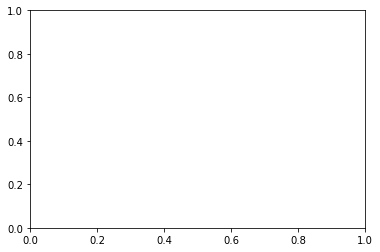

In [ ]:
"""
Plot the average helical wavelength as a function of azimuthal angle.
"""

plt.plot( np.arange(0, 180, 1.5), fit_constant/radii,)

In [ ]:
"""
The next step is to parse the full soliton data! This is done in the results
python notebook.
"""


Processing scan 687537-pixis-files (angle=0.0) at 0 mT.


NameError: name 'CCDImage' is not defined